In [138]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, LogLocator

# Load the JSON file
data = pd.read_json('../VUEs.json')

# Convert to a DataFrame
df = pd.DataFrame(data)


# Normalize the 'revisedProteinEffects' column
normalized_dfs = []
for index, row in df.iterrows():
    normalized_row = pd.json_normalize(row['revisedProteinEffects'])
    repeated_row = pd.DataFrame([row.drop('revisedProteinEffects')] * len(normalized_row)).reset_index(drop=True)
    combined = pd.concat([repeated_row.reset_index(drop=True), normalized_row], axis=1).reset_index(drop=True)
    normalized_dfs.append(combined)

# Determine the union of all column names
all_columns = set()
for df in normalized_dfs:
    all_columns.update(df.columns)

# Reindex each DataFrame to include all columns, filling missing values with NaN
all_columns = list(all_columns)
for i, df in enumerate(normalized_dfs):
    normalized_dfs[i] = df.loc[:, ~df.columns.duplicated()].reindex(columns=all_columns)

# Concatenate all normalized DataFrames
result_df = pd.concat(normalized_dfs, ignore_index=True)

In [103]:
result_df[result_df.hugoGeneSymbol == "KIT"]

,hugoGeneSymbol,revisedProteinEffect,vepPredictedVariantClassification,hgvsc,counts.mskimpact.somaticVariantsCount,counts.genie.germlineVariantsCount,mutationOrigin,otherVariation,counts.mskimpact.unknownVariantsCount,counts.mskimpact_nonsignedout.unknownVariantsCount,...,variant,counts.mskimpact_nonsignedout.somaticVariantsCount,defaultEffect,counts.mskimpact.totalPatientCount,counts.genie.totalPatientCount,variantNote,counts.mskimpact_nonsignedout.genePatientCount,counts.tcga.somaticVariantsCount,genomicLocation,comment
0,KIT,p.K550_K558del,Splice_Site,ENST00000288135.5:c.1648-6_1672del,3,0,NaN,NaN,0,0,...,4:g.55593576_55593606del,0,splice,70067,60702,NaN,44,0,"4,55593576,55593606,CCACAGAAACCCATGTATGAAGTACA...","Changes splice donor site, cause inframe delet..."
1,KIT,p.K550_K558del,Splice_Site,ENST00000288135.5:c.1648_1674del,5,0,NaN,NaN,0,0,...,4:g.55593580_55593606del,0,splice,70067,60702,NaN,44,0,"4,55593580,55593606,AGAAACCCATGTATGAAGTACAGTGGA,-","Changes splice donor site, cause inframe delet..."
2,KIT,p.K550_K558del,Splice_Site,ENST00000288135.5:c.1648-3_1673del,3,0,NaN,NaN,0,0,...,4:g.55593578_55593606del,0,splice,70067,60702,NaN,44,0,"4,55593578,55593606,ACAGAAACCCATGTATGAAGTACAGT...","Changes splice donor site, cause inframe delet..."


In [161]:
# hardcoded set o fgene swith highest level (manually determined with
# mutationmapper, and just looking upn genes in OncoKB)
highest_level_per_gene = {
    "KIT": "Level 1",
    "MET": "Level 1",
    "FLT3": "Level 1",
    "ATM": "Level 1",
    "BRCA1": "Level 1",
    "BRCA2": "Level 1",
    "BRIP1": "Level 1",
    "CHEK2": "Level 1",
    "PALB2": "Level 1",
    "RAD51D": "Level 1",
    "MLH1": "Level 1",
    "EGFR": "Level 1",
}

In [166]:

grouped_df = result_df.groupby('hugoGeneSymbol').agg({'hugoGeneSymbol': 'count', 'counts.mskimpact.somaticVariantsCount': 'sum', 'counts.tcga.somaticVariantsCount': 'sum', 'counts.genie.somaticVariantsCount': 'sum'})
grouped_df.columns = ['Number of VUEs', 'mskimpact', 'tcga', 'genie']
grouped_df['total_variant_count'] = grouped_df[['mskimpact', 'tcga', 'genie']].sum(axis=1)
grouped_df['Highest_Level'] = grouped_df.index.map(highest_level_per_gene).fillna('Oncogenic')
grouped_df.head()

,Number of VUEs,mskimpact,tcga,genie,total_variant_count,Highest_Level
hugoGeneSymbol,,,,,,
APC,1,0,0,0,0,Oncogenic
ATM,10,1,0,0,1,Level 1
BAP1,1,0,0,0,0,Oncogenic
BRCA1,2,2,0,1,3,Level 1
BRCA2,4,0,0,0,0,Level 1


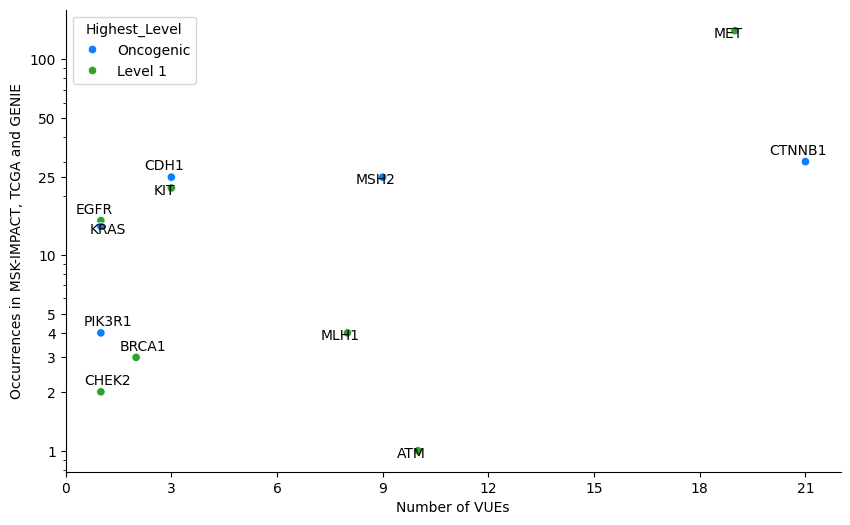

In [174]:
from matplotlib.ticker import MaxNLocator, LogLocator, ScalarFormatter
from adjustText import adjust_text

# Create the scatter plot
plt.figure(figsize=(10, 6))


palette = {"Level 1": "#30A12D", "Oncogenic": "#0780FE"}

scatter_plot = sns.scatterplot(data=grouped_df, x='Number of VUEs', y='total_variant_count', hue="Highest_Level", palette=palette)

# Despine the plot
sns.despine()

# Set x-axis to display integers only
scatter_plot.xaxis.set_major_locator(MaxNLocator(integer=True))
# Set y-axis to log scale
scatter_plot.set_yscale('log')
# Manually set y-axis ticks
scatter_plot.set_yticks([1, 2, 3, 4, 5, 10, 25, 50, 100])
scatter_plot.get_yaxis().set_major_formatter(ScalarFormatter())


# Add labels and title
scatter_plot.set_xlabel('Number of VUEs')
scatter_plot.set_ylabel('Occurrences in MSK-IMPACT, TCGA and GENIE')

# Add annotations for each point with gene symbols
texts = []
for i, row in grouped_df.iterrows():
    # Add some randomness to the initial text position
    x_offset = np.random.choice([5, -5])
    y_offset = np.random.choice([5, -5])
    texts.append(scatter_plot.annotate(row.name, 
                          (row['Number of VUEs'], row['total_variant_count']),
                          textcoords="offset points", xytext=(x_offset, y_offset), ha='center'))

# Show the plot
plt.show()

In [181]:
result_df[result_df['hugoGeneSymbol'] == 'APC'].to_dict('records')

[{'hugoGeneSymbol': 'APC',
  'revisedProteinEffect': 'p.G279Ffs*10',
  'vepPredictedVariantClassification': 'Splice_Region',
  'hgvsc': 'ENST00000257430.4:c.835-8A>G',
  'counts.mskimpact.somaticVariantsCount': 0,
  'counts.genie.germlineVariantsCount': 0,
  'mutationOrigin': nan,
  'otherVariation': nan,
  'counts.mskimpact.unknownVariantsCount': 0,
  'counts.mskimpact_nonsignedout.unknownVariantsCount': 0,
  'references': [{'pubmedId': '29316426',
    'referenceText': 'Yaeger et al., 2018'}],
  'counts.genie.unknownVariantsCount': 0,
  'confirmed': True,
  'transcriptId': 'ENST00000257430',
  'counts.tcga.totalPatientCount': 10953,
  'context': 'Recurrent alteration in CRC',
  'revisedStandardVariantClassification': 'Frame_Shift_Ins',
  'revisedVariantClassification': 'Splice_Exon_Extension_Out_Of_Frame',
  'genomicLocationDescription': '5:g.112151184A>G',
  'counts.genie.somaticVariantsCount': 0,
  'counts.mskimpact_nonsignedout.totalPatientCount': 87119,
  'counts.mskimpact.genePat

In [176]:
grouped_df[grouped_df.total_variant_count == 0]
# TODO: Need to fix these:
# APC should be in nonsigned out MSK-IMPACT data many times (see e.g. Yaeger pub)
# RAD51D is in CCLE and a germline event in MSK SOLID HEME

,Number of VUEs,mskimpact,tcga,genie,total_variant_count,Highest_Level
hugoGeneSymbol,,,,,,
APC,1,0,0,0,0,Oncogenic
BAP1,1,0,0,0,0,Oncogenic
BRCA2,4,0,0,0,0,Level 1
BRIP1,2,0,0,0,0,Level 1
F11,3,0,0,0,0,Oncogenic
FLT3,1,0,0,0,0,Level 1
PALB2,2,0,0,0,0,Level 1
RAD51D,1,0,0,0,0,Level 1
RB1,1,0,0,0,0,Oncogenic


In [159]:
# create input for mutationmapper tool

# Create new DataFrame with the specified columns
new_data = {
    'Sample_ID': [],
    'Cancer_Type': [],
    'Chromosome': [],
    'Start_Position': [],
    'End_Position': [],
    'Reference_Allele': [],
    'Variant_Allele': []
}

# Fill in the new DataFrame
for location in result_df['genomicLocation']:
    try:
        chrom, start, end, ref, alt = location.split(',')
    except ValueError:
        continue
    new_data['Sample_ID'].append(f'Sample_{np.random.randint(1, 1000)}')
    new_data['Cancer_Type'].append(np.random.choice(['Lung', 'Breast', 'Colon', 'Prostate', 'Leukemia']))
    new_data['Chromosome'].append(chrom)
    new_data['Start_Position'].append(start)
    new_data['End_Position'].append(end)
    new_data['Reference_Allele'].append(ref)
    new_data['Variant_Allele'].append(alt)

new_df = pd.DataFrame(new_data)

# Copy the new DataFrame for pasting into MutationMapperTool
new_df.to_clipboard(index=False)


In [160]:
highest_level_per_gene = {
    "KIT": "Level 1",
    "MET": "Level 1",
    "FLT3": "Level 1",
    "ATM": "Level 1",
    "BRCA1": "Level 1",
    "BRCA2": "Level 1",
    "BRIP1": "Level 1",
    "CHEK2": "Level 1",
    "PALB2": "Level 1",
    "RAD51D": "Level 1",
    "MLH1": "Level 1",
    "EGFR": "Level 1",
}